# Building micrograd

In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
  return 3*x**2 - 4*x + 5

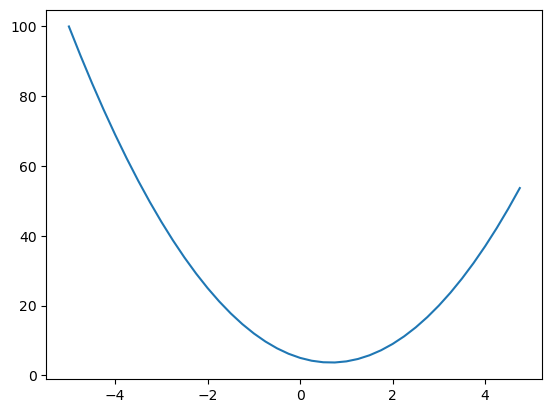

In [3]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs,ys)

In [4]:
h = 0.000000001
x = 2/3
(f(x+h)-f(x))/h

0.0

In [5]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


If we bump `a` slighlty then `d2` goes down, if we bump `b` slightly then `d2` gose up, if we bump `c` then `d2` goes up

In [6]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


## Implement `Value` wrapper

In [7]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._prev = set(_children)
    self._op = _op
    self.label = label
    
    self._backward = lambda: None
    
  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out
  
  def __sub__(self, other):
    return self + (-other)
  
  def __neg__(self):
    return self * -1
  
  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out
  
  def __rmul__(self, other):
    return self * other
  
  def __radd__(self, other):
    return self + other
  
  def __truediv__(self, other):
    return self * other ** -1
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), 'only int/float is supported for pow'
    out = Value(self.data**other, (self,), f'**{other}')
    def _backward():
      self.grad += other * self.data ** (other - 1) * out.grad
      
    out._backward = _backward
    return out
  
  def tanh(self):
    n = self.data;
    t = (math.exp(2*n) - 1)/(math.exp(2*n)+1)
    out = Value(t, (self, ), 'tanh')
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
       self.grad += out.data * out.grad
    out._backward = _backward;
    return out
  
  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    self.grad = 1.0
    for node in reversed(topo):
      node._backward();

In [8]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b
e.label='e'

d = e + c
d.label = 'd'

f = Value(-2.0, label='f')
L = d * f
L.label = 'L'

L

Value(data=-8.0)

We need to keep track of operations — what number resulted in what calculation.

We're adding `_prev` pointer to Value, and `_op` that was applied to it.

In [9]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    # dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

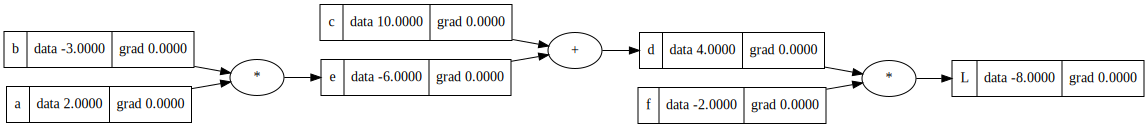

In [10]:
draw_dot(L)

Adding `grad` to implement backpropagation

In [11]:
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0

Use Chain Rule to find out `dL/dc`

In [12]:
c.grad = -2.0
e.grad = -2.0

and `dL/da`

In [13]:
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

Manual forward step

In [14]:
stepSize = 0.01
a.data += a.grad * stepSize
b.data += b.grad * stepSize
c.data += c.grad * stepSize
f.data += f.grad * stepSize

e = a*b
d = e+c
L = d*f
print(L.data)

-7.286496


**Check gradients manually with this funciton**

In [15]:
def lol():
  
  h = 0.001
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data
  
  a = Value(2.0, label='a')
#  a.data += h
  b = Value(-3.0, label='b')
  b.data += h
  c = Value(10.0, label='c')
#  c.data +=h
  e = a*b; e.label = 'e'
#  e.data += h
  d = e + c; d.label = 'd'
#  d.data += h
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data
  #   L2 = L.data + h
  
  print((L2-L1)/h)
lol()  

-3.9999999999995595


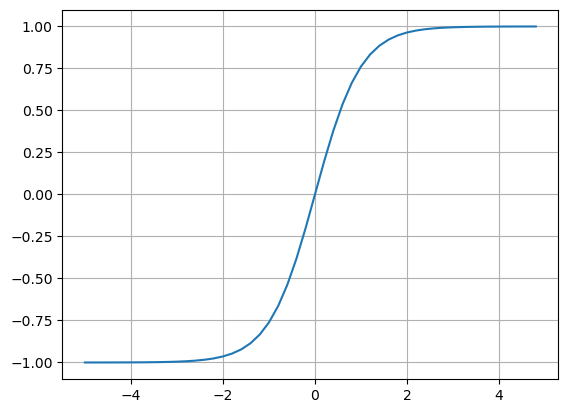

In [16]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid()

Basic neuron

In [17]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

Go back to `Value` and implement`tanh`. We don't necessary need to implement everything from simplest operations, so we just put formula for `tanh` in the method.

Doing backpropagation for this neuron:

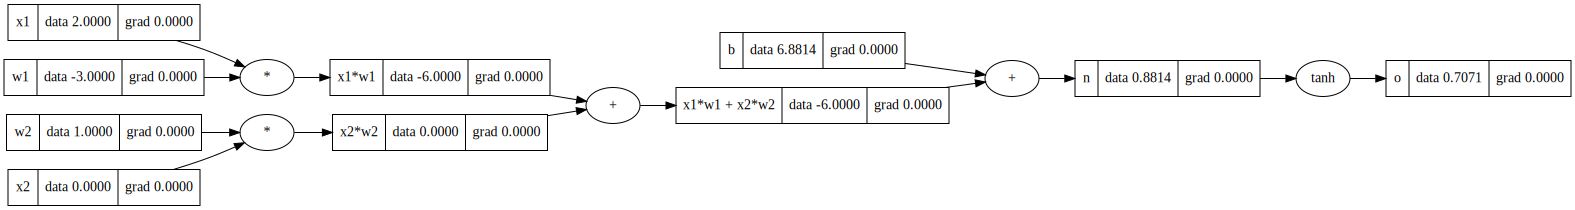

In [18]:
draw_dot(o)

In [19]:
o.backward()

In [20]:
o.grad = 1.0

In [21]:
n.grad = 0.5

In [22]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [23]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [24]:
x2.grad = w2.data * x2w2.grad
w2.grad = w2.data * x2w2.grad

In [25]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [26]:
1 - o.data**2

0.4999999999999999

Using backpropagatoin

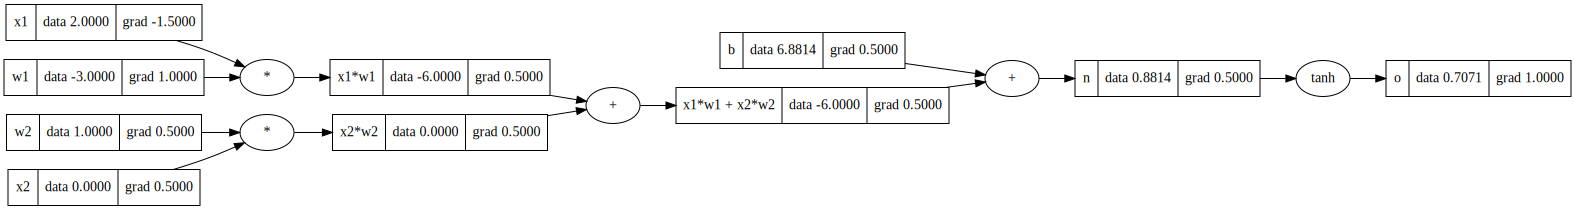

In [27]:
draw_dot(o)

In [28]:
o.grad = 1.0

In [29]:
o._backward()

In [30]:
n._backward()

In [31]:
b._backward() # nothing should happen

In [32]:
x1w1x2w2._backward()

In [33]:
x1w1._backward()
x2w2._backward()

Calling `backward` automatcally.

Topologically sort a graph, then visit each node, marking each visit.

In [34]:
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

Add this to the value in the form of `backward` function

There is a bug when using variable more than once:

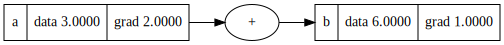

In [35]:
a = Value(3.0, label='a')
b = a + a
b.label = 'b'
b.backward()
draw_dot(b)

After fix

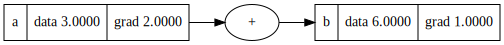

In [36]:
a = Value(3.0, label='a')
b = a + a
b.label = 'b'
b.backward()
draw_dot(b)

`Value` can't do operations with primitive values

In [37]:
a = Value(2)
a + 1

Value(data=3)

In [38]:
a = Value(2)
a + 1

Value(data=3)

In [39]:
a = Value(2)
a * 1

Value(data=2)

In [40]:
1 * a

Value(data=2)

fixing with `__rmul__`:

In [41]:
a = Value(2.0)
1 * a

Value(data=2.0)

Add `exp`

In [42]:
a = Value(2.0)
a.exp()

Value(data=7.38905609893065)

Implementing division in terms of `a * (b ** -1)`. Need to implement `**`

More complex expression: replace tanh with expression. Check that `o.grad` is the same, and `w1.grad`, `w2.grad` are the same as before

In [43]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'

#---
e = (2*n).exp()
o = (e -1) / (e+1)
#---
o.label = 'o'
o.backward()

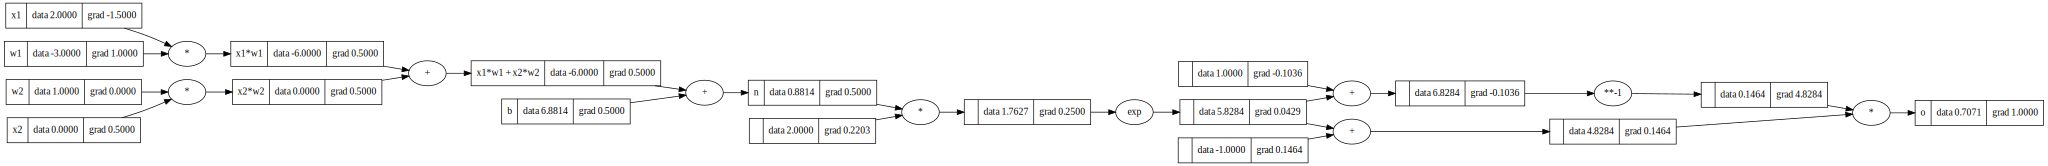

In [44]:
draw_dot(o)

## Building `Neuron` + `MLP`

In [218]:
class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
    
  def __call__(self, x):
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]
  
class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

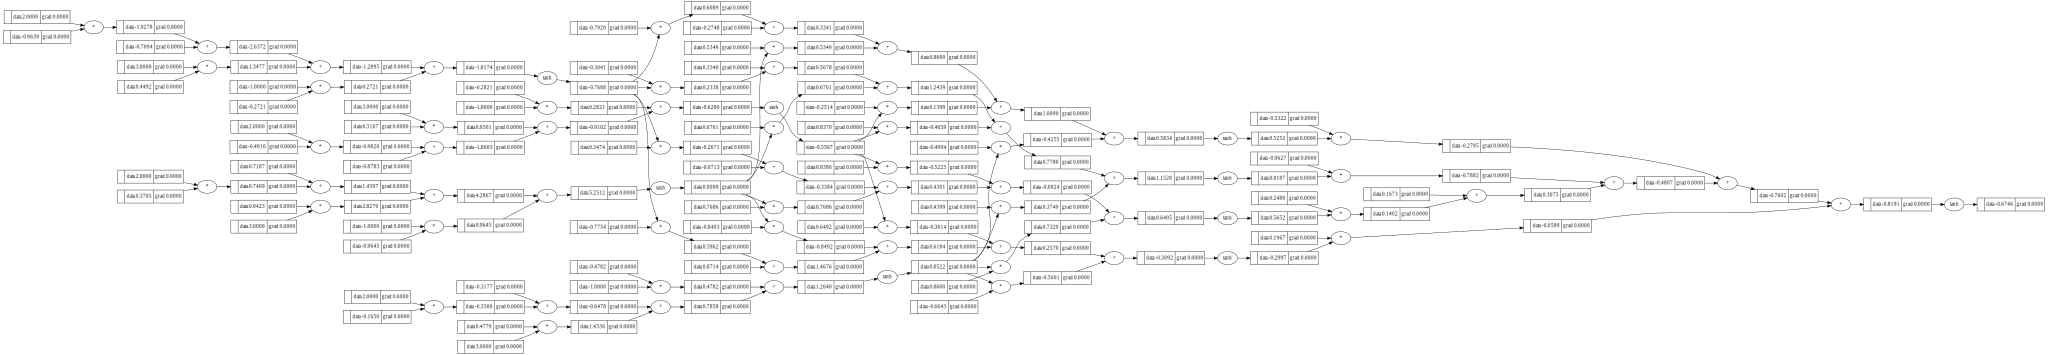

In [47]:
draw_dot(n(x))

## Loss

In [219]:
# initialise the net
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=0.6250099951220124)

In [65]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

### Manual Training

In [207]:
# Forward pass
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) # mean squared error loss
loss

Value(data=0.0008043391368227915)

In [205]:
loss.backward()

In [206]:
for p in n.parameters():
  p.data += -0.01 * p.grad # 0.1 (till ~0.xxx) -> 0.01

In [210]:
ypred

[Value(data=0.9908609364740304),
 Value(data=-0.9795852959382159),
 Value(data=-0.9849834820103223),
 Value(data=0.991136552576647)]

## Auto-traininig

In [282]:
for k in range(10):
  
  # forward
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update (2:15:26 stochastic gradient descent update)
  for p in n.parameters():
    p.data += -0.05 * p.grad # "learning rate decay" — the bigger the step the less we adjust the value 
  
  print(k, loss.data)

0 0.0010095989012932874
1 0.001007836766658763
2 0.0010060806585637594
3 0.001004330546389505
4 0.0010025863997233301
5 0.0010008481883569094
6 0.0009991158822845619
7 0.000997389451701547
8 0.000995668867002413
9 0.0009939540987793246


In [283]:
ypred

[Value(data=0.9854731652112899),
 Value(data=-0.9839744684638739),
 Value(data=-0.9865941016107493),
 Value(data=0.9813884606450041)]